In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler


dataset = pd.read_csv("/content/drive/MyDrive/Minor_project/preprocessed_datasset.csv",index_col=0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X = dataset.iloc[:,:-1]
Y = dataset.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train , x_test , Y_train , y_test = train_test_split(X,Y,test_size=0.2 , random_state=100)

X_train = sc.fit_transform(X_train)
x_test = sc.fit_transform(x_test)



In [14]:
!pip install keras-tuner
from kerastuner.tuners import RandomSearch,Hyperband
from keras.regularizers import l2


In [29]:
def build_model(hp):
  model = Sequential()
  for i in range(hp.Int('num_layers',2,15)):
    model.add(Dense(units=hp.Int('uints_'+str(i),
                                 min_value=32,
                                 max_value=512,
                                 step=32),
                     activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer=keras.optimizers.Adam(
      hp.Choice('learning_rate',[1e-2,1e-3,1e-4])),
      loss='binary_crossentropy' ,
      metrics=['accuracy'])
  
  return model

In [30]:
tuner = RandomSearch(build_model,
                     objective='lossy',max_trials=10,executions_per_trial=5,
                     directory='project',project_name='model2_10')

INFO:tensorflow:Reloading Oracle from existing project project/model2_10/oracle.json


In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 15, 'step': 1, 'sampling': None}
uints_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
uints_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [32]:
tuner.search(X_train,Y_train,
             epochs=10,batch_size=64,validation_data=(x_test,y_test))

Trial 10 Complete [00h 05m 00s]
val_accuracy: 0.761467432975769

Best val_accuracy So Far: 0.761467432975769
Total elapsed time: 00h 50m 01s
INFO:tensorflow:Oracle triggered exit


In [42]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""The hyperparameter search is complete. 
The optimal number of units in the first densely-connectedlayer is {best_hps.get('uints_0')}
 and the optimal learning rate for the optimizeris {best_hps.get('learning_rate')}.""")

The hyperparameter search is complete. 
The optimal number of units in the first densely-connectedlayer is 160
 and the optimal learning rate for the optimizeris 0.0001.


In [47]:
# Build the model with the optimal hyperparameters and train it on the data for 200 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=200,batch_size=64,validation_data=(x_test,y_test))

Epoch 1/200
1530/1530 [==============================] - 7s 4ms/step - loss: 9.6105 - accuracy: 0.7120 - val_loss: 0.9790 - val_accuracy: 0.7495
Epoch 2/200
1530/1530 [==============================] - 6s 4ms/step - loss: 0.8362 - accuracy: 0.7501 - val_loss: 0.6493 - val_accuracy: 0.7547
Epoch 3/200
1530/1530 [==============================] - 6s 4ms/step - loss: 0.6347 - accuracy: 0.7528 - val_loss: 0.6049 - val_accuracy: 0.7454
Epoch 4/200
1530/1530 [==============================] - 6s 4ms/step - loss: 0.5964 - accuracy: 0.7535 - val_loss: 0.5741 - val_accuracy: 0.7588
Epoch 5/200
1530/1530 [==============================] - 6s 4ms/step - loss: 0.5733 - accuracy: 0.7559 - val_loss: 0.5597 - val_accuracy: 0.7593
Epoch 6/200
1530/1530 [==============================] - 6s 4ms/step - loss: 0.5609 - accuracy: 0.7597 - val_loss: 0.5514 - val_accuracy: 0.7595
Epoch 7/200
1530/1530 [==============================] - 6s 4ms/step - loss: 0.5512 - accuracy: 0.7601 - val_loss: 0.5699 - val_ac

In [48]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 198


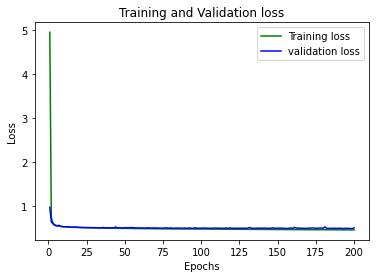

In [49]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,201)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

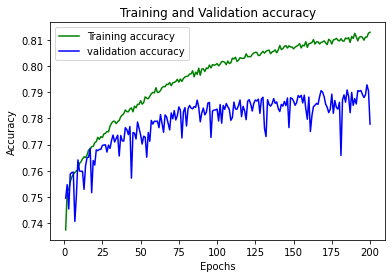

In [51]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,201)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [55]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, Y_train, epochs=best_epoch,batch_size=64,validation_data=(x_test,y_test))

Epoch 1/198
1530/1530 [==============================] - 7s 4ms/step - loss: 9.5149 - accuracy: 0.6889 - val_loss: 0.9318 - val_accuracy: 0.7524
Epoch 2/198
1530/1530 [==============================] - 6s 4ms/step - loss: 0.8063 - accuracy: 0.7495 - val_loss: 0.6503 - val_accuracy: 0.7400
Epoch 3/198
1530/1530 [==============================] - 6s 4ms/step - loss: 0.6260 - accuracy: 0.7556 - val_loss: 0.5882 - val_accuracy: 0.7586
Epoch 4/198
1530/1530 [==============================] - 6s 4ms/step - loss: 0.5835 - accuracy: 0.7581 - val_loss: 0.5672 - val_accuracy: 0.7568
Epoch 5/198
1530/1530 [==============================] - 6s 4ms/step - loss: 0.5665 - accuracy: 0.7560 - val_loss: 0.5554 - val_accuracy: 0.7586
Epoch 6/198
1530/1530 [==============================] - 6s 4ms/step - loss: 0.5554 - accuracy: 0.7562 - val_loss: 0.5479 - val_accuracy: 0.7579
Epoch 7/198
1530/1530 [==============================] - 6s 4ms/step - loss: 0.5501 - accuracy: 0.7595 - val_loss: 0.5415 - val_ac

In [56]:
eval_result = hypermodel.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

765/765 [==============================] - 2s 2ms/step - loss: 0.4988 - accuracy: 0.7911
[test loss, test accuracy]: [0.4988466501235962, 0.7910776734352112]


In [57]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160)               15520     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               82432     
_________________________________________________________________
dense_2 (Dense)              (None, 480)               246240    
_________________________________________________________________
dense_3 (Dense)              (None, 224)               107744    
_________________________________________________________________
dense_4 (Dense)              (None, 192)               43200     
_________________________________________________________________
dense_5 (Dense)              (None, 96)                18528     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2

In [58]:
hypermodel.save('predictor_v5.h5')